In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Real Life Violence Detection model

If you want to checkout the run scripts version, you can refer to this github link.
Gihub repo - [Real Life Violence Detection model](https://github.com/NANDINI-star/Real-life-violence-detection)

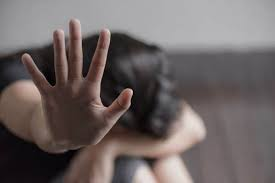

# Extract frames from video

In [ ]:
import cv2
import os
import sys
import glob
from tqdm import tqdm

In [ ]:
PATH_violence = "ENTER_PATH_OF_VIOLENT_VIDEOS"

In [ ]:
os.makedirs('./data/Violence',exist_ok=True)
for path in tqdm(glob.glob(PATH_violence+'/*')):
    fname = os.path.basename(path).split('.')[0]
    vidcap = cv2.VideoCapture(path)
    success,image = vidcap.read()
    count = 0
    while success:
        if count % 5 == 0:
            cv2.imwrite("./data/Violence/{}-{}.jpg".format(fname,str(count).zfill(4)),image)     # save frame as JPEG file      
        success,image = vidcap.read()
        count += 1

In [ ]:
PATH_nonviolence = 'ENTER_PATH_OF_NON_VIOLENT_VIDEOS'

In [ ]:
os.makedirs('./data/NonViolence',exist_ok=True)
for path in tqdm(glob.glob(PATH_nonviolence+'/*')):
    fname = os.path.basename(path).split('.')[0]
    vidcap = cv2.VideoCapture(path)
    success,image = vidcap.read()
    count = 0
    while success:
        if count % 5 == 0:
            cv2.imwrite("./data/NonViolence/{}-{}.jpg".format(fname,str(count).zfill(4)),image)     # save frame as JPEG file      
        success,image = vidcap.read()
        count += 1

# Creating the video classification model

In [ ]:
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.pooling import AveragePooling2D
from keras.applications import ResNet50,MobileNetV2,MobileNet,InceptionV3
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.utils import to_categorical 
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import warnings
import argparse
import pickle
import cv2
import os

In [ ]:
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)

In [ ]:
args = {
    "dataset": "data",
    "model": "model/violence_model.h5",
    "label-bin": "model/lb.pickle",
    "epochs": 10,
    "plot": "plot.png"
    
}


In [ ]:
# initialize the set of labels from the spots activity dataset we are
# going to train our network on
LABELS = set(["Violence", "NonViolence"])

In [ ]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print('-'*100)
print("[INFO] loading images...")
print('-'*100)
imagePaths = list(paths.list_images(args["dataset"]))
data = []
labels = []

## Resizing the images

In [ ]:
# loop over the image paths
for imagePath in tqdm(imagePaths[::]):
    # imagePath : file name ex) V_123
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2] # Violence / NonViolence

    # if the label of the current image is not part of of the labels
    # are interested in, then ignore the image
    if label not in LABELS:
        continue

    # load the image, convert it to RGB channel ordering, and resize
    # it to be a fixed 224x224 pixels, ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

In [ ]:
# convert the data and labels to NumPy arrays
data = np.array(data)
labels = np.array(labels)

In [ ]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

LabelBinarizer returns output as numpy array. LabelBinarizer is used for one-hot encoding of categorical variables.

In [ ]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, stratify=labels, random_state=42)

## Training Data Augmentation

In [ ]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [ ]:
# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator()

In [ ]:
# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

## Load InceptionV3 model

In [ ]:
# load the InceptionV3 network, ensuring the head FC layer sets are left
# off
baseModel = InceptionV3(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

In [ ]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(5, 5))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(lb.classes_), activation="softmax")(headModel)

In [ ]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the training process
model.trainable = True

## Compile the model

In [ ]:
# compile our model (this needs to be done after our setting our
# layers to being non-trainable)
print('-'*100)
print("[INFO] compiling model...")
print('-'*100)
opt = SGD(lr=1e-4, momentum=0.9, decay=1e-4 / args["epochs"])
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
print(model.summary())

## Train the model

In [ ]:
# train the head of the network for a few epochs (all other layers
# are frozen) -- this will allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random
print('-'*100)
print("[INFO] training head...")
print('-'*100)
H = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=32),
    steps_per_epoch=len(trainX) // 32,
    validation_data=valAug.flow(testX, testY),
    validation_steps=len(testX) // 32,
    epochs=args["epochs"])

## Evaluate the network

In [ ]:
# evaluate the network
print('-'*100)
print("[INFO] evaluating network...")
print('-'*100)
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=lb.classes_))

In [ ]:
# plot the training loss and accuracy
print('-'*100)
print("[INFO] plot the training loss and accuracy...")
print('-'*100)
N = args["epochs"]
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])

In [ ]:
# serialize the model to disk
print('-'*100)
print("[INFO] serializing network...")
print('-'*100)
model.save(args["model"])

In [ ]:
# serialize the label binarizer to disk
f = open(args["label-bin"], "wb")
f.write(pickle.dumps(lb))
f.close()

# Predict the video for violence/ non-violence

In [ ]:
from keras.models import load_model
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import cv2

In [ ]:
args = {

    "model": "model/violence_model.h5",
    "label-bin": "model/lb.pickle",
    "input": "video/street-fight.mp4",
    "output": "output/streetfight_64avg.avi",
    "size": 64
    
}


In [ ]:
# load the trained model and label binarizer from disk
print("[INFO] loading model and label binarizer...")
model = load_model(args["model"])
lb = pickle.loads(open(args["label-bin"], "rb").read())

In [ ]:
# initialize the image mean for mean subtraction along with the
# predictions queue
mean = np.array([123.68, 116.779, 103.939][::1], dtype="float32")
Q = deque(maxlen=args["size"])

In [ ]:
# initialize the video stream, pointer to output video file, and
# frame dimensions
vpath = args["input"]
if args["input"] == 'camera':
	vpath = 0
vs = cv2.VideoCapture(vpath)
writer = None
(W, H) = (None, None)

In [ ]:
# loop over frames from the video file stream
while True:
    # read the next frame from the file
    (grabbed, frame) = vs.read()

    # if the frame was not grabbed, then we have reached the end
    # of the stream
    if not grabbed:
        break

    # if the frame dimensions are empty, grab them
    if W is None or H is None:
        (H, W) = frame.shape[:2]

    # clone the output frame, then convert it from BGR to RGB
    # ordering, resize the frame to a fixed 224x224, and then
    # perform mean subtraction
    output = frame.copy()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, (224, 224)).astype("float32")
    frame -= mean

    # make predictions on the frame and then update the predictions
    # queue
    preds = model.predict(np.expand_dims(frame, axis=0))[0]
    Q.append(preds)

    # perform prediction averaging over the current history of
    # previous predictions
    results = np.array(Q).mean(axis=0)
    # i = np.argmax(results)
    i = 1
    label = lb.classes_[i]
    

    # draw the activity on the output frame
    # prob = model.predict_proba(np.expand_dims(frame, axis=0))[0] # to show probability of frame
    prob = results[i]*100

    text_color = (0, 255, 0) # default : green

    if prob > 70 : # Violence prob
        text_color = (0, 0, 255) # red
        
    else:
        label = 'Normal'

    text = "State : {:8} ({:3.2f}%)".format(label,prob)
    FONT = cv2.FONT_HERSHEY_SIMPLEX 

    cv2.putText(output, text, (35, 50), FONT,1.25, text_color, 3) 

    # plot graph over background image
    output = cv2.rectangle(output, (35, 80), (35+int(prob)*5,80+20), text_color,-1)

    # check if the video writer is None
    if writer is None:
        # initialize our video writer
        fourcc = cv2.VideoWriter_fourcc(*"MJPG")
        writer = cv2.VideoWriter(args["output"], fourcc, 30,(W, H), True)

    # write the output frame to disk
    writer.write(output)

    # show the output image
    cv2.imshow("Output", output)
    key = cv2.waitKey(1) & 0xFF

    # if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break
# release the file pointersq
print("[INFO] cleaning up...")
writer.release()
vs.release()